In [1]:
!pip install perceval-quandela

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.3/884.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 860.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.1 MB/s eta 0:00:00


In [2]:
import perceval as pcvl
import perceval.components as comp

from perceval.components import PS, BS, PERM, Port
import numpy as np

from perceval.rendering.circuit import DisplayConfig, SymbSkin, PhysSkin
from perceval.utils import Encoding

# Grover's Algorithm

Now that we've simplified the circuit for Grover's algorithm in Qiskit and taken care of bias, we can easily map these results to Perceval, making use of the fact that the Z gate in Perceval is a π-phase shifter.


In [3]:
delta1 = pcvl.Parameter("delta1")
xsi1 = pcvl.Parameter("xsi1")

delta2 = pcvl.Parameter("delta2")
xsi2 = pcvl.Parameter("xsi2")

delta3 = pcvl.Parameter("delta3")
xsi3 = pcvl.Parameter("xsi3")

phi1 = pcvl.Parameter("phi1")

In [4]:
delta1.set_value(np.pi/2)
xsi1.set_value(np.pi/8)

delta2.set_value(np.pi/2)
xsi2.set_value(np.pi/4)

delta3.set_value(np.pi/2)
xsi3.set_value(0)

In [6]:
grover = (pcvl.Circuit(4)
        .add(1, comp.BS().H())

        .add(1, comp.WP(delta=delta1, xsi=xsi1)) # oracle marking
        .add(1, comp.WP(delta=delta1, xsi=xsi1)) # oracle marking

        .add(1, comp.BS().H())
        .add(0, comp.PBS())
        .add(2, comp.PBS())

        .add(1, comp.WP(delta=delta1, xsi=xsi1))
        .add(2, comp.WP(delta=delta1, xsi=xsi1))

        .add(1, comp.PS(np.pi))
        .add(2, comp.PS(np.pi))

        .add(1, comp.BS().H())
        .add(0, comp.PBS())
        .add(2, comp.PBS())

        .add(1, comp.WP(delta=delta1, xsi=xsi1))
        .add(2, comp.WP(delta=delta1, xsi=xsi1)))

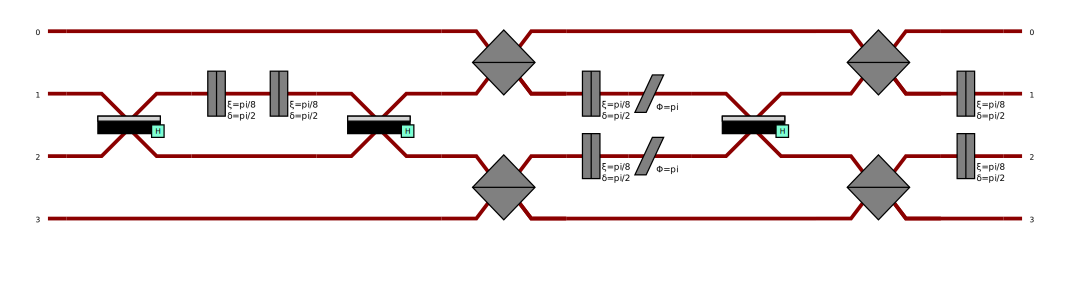

In [7]:
pcvl.pdisplay(grover)

In [9]:
processor = pcvl.Processor("SLOS", grover)
processor.add_port(0, Port(Encoding.DUAL_RAIL, 'port1'))
processor.add_port(2, Port(Encoding.DUAL_RAIL, 'port2'))

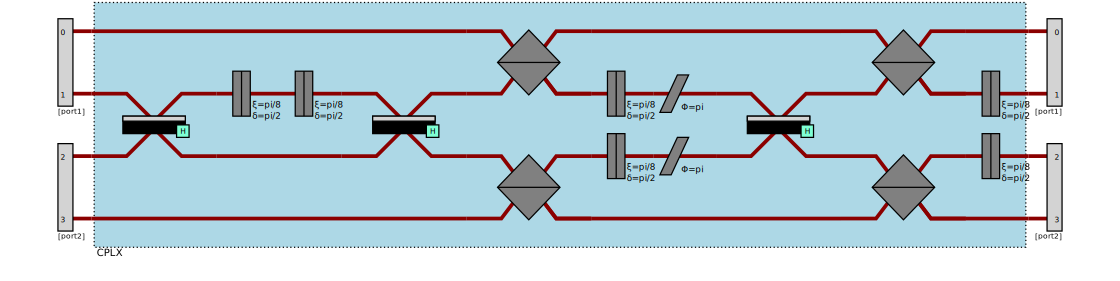

In [10]:
pcvl.pdisplay(processor, recursive=True)

In [11]:
input_state = pcvl.BasicState("|0,1,0,0>")
processor.with_input(input_state)
sampler = pcvl.algorithm.Sampler(processor)
sample_count = sampler.sample_count(10000)

In [12]:
print(sample_count['results'])

{
  |0,0,1,0>: 10000
}


In [13]:
results_dict = dict(sample_count['results'])
possible_keys = ["|1,0,0,0>", "|0,1,0,0>", "|0,0,1,0>", "|0,0,0,1>"]
padded_results_dict = {}
stringified_results_dict = {str(k): v for k, v in results_dict.items()}
padded_results_dict = {k: int(stringified_results_dict.get(k, 0)) for k in possible_keys}

print(padded_results_dict)


{'|1,0,0,0>': 0, '|0,1,0,0>': 0, '|0,0,1,0>': 10000, '|0,0,0,1>': 0}


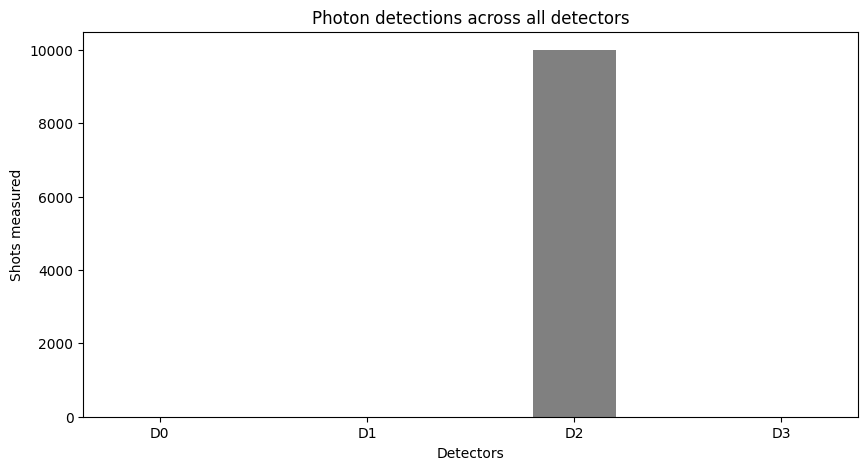

In [14]:
import matplotlib.pyplot as plt

detectors = ["D0", "D1", "D2", "D3"]
values = list(padded_results_dict.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(detectors, values, color ='gray',
        width = 0.4)

plt.xlabel("Detectors")
plt.ylabel("Shots measured")
plt.title("Photon detections across all detectors")
plt.show()

**Key finding**: These results match our Qiskit simulation, as the spatial mode qubits were detected in a single state (|w>) at detector 2. Therefore, Grover's algorithm was implemented successfully.


# Grover's Algorithm With Noise

Similar to what we did in Qiskit, we can create a more accurate simulation by infusing noise into our circuit.

Because the Perceval framework doesn't include built-in customizable noise models, we can manually simulate noise by adding random phase shifters at different points in the circuit. To match realistic photonic NISQ devices, we will define the amount of phase shift as follows:

In [15]:
def random_phase_shift():
   return np.random.uniform(0, np.pi/6)

Now, we can go through the full implementation.

In [16]:
def create_grovers_with_noise(phase_noise):
  grover = (pcvl.Circuit(4)
        .add(1, comp.BS().H())

        .add(0, comp.PS(phase_noise))
        .add(1, comp.PS(phase_noise))

        .add(1, comp.WP(delta=delta1, xsi=xsi1)) # oracle marking
        .add(1, comp.WP(delta=delta1, xsi=xsi1)) # oracle marking

        .add(1, comp.BS().H())
        .add(0, comp.PBS())
        .add(2, comp.PBS())

        .add(1, comp.WP(delta=delta1, xsi=xsi1))
        .add(2, comp.WP(delta=delta1, xsi=xsi1))

        .add(1, comp.PS(np.pi))
        .add(2, comp.PS(np.pi))

        .add(1, comp.BS().H())
        .add(0, comp.PBS())
        .add(2, comp.PBS())

        .add(1, comp.WP(delta=delta1, xsi=xsi1))
        .add(2, comp.WP(delta=delta1, xsi=xsi1)))
  return grover


In [17]:
def simulate_circuit_with_noise(phase_noise, shots=10000):
  mzi = create_grovers_with_noise(phase_noise)
  processor = pcvl.Processor("SLOS", mzi)
  processor.add_port(0, Port(Encoding.DUAL_RAIL, 'port1'))
  processor.add_port(2, Port(Encoding.DUAL_RAIL, 'port2'))
  input_state = pcvl.BasicState("|0,1,0,0>")
  processor.with_input(input_state)
  sampler = pcvl.algorithm.Sampler(processor)
  sample_count = sampler.sample_count(10000)
  counts = sample_count['results']
  return counts

In [18]:
noise_levels = np.linspace(0, np.pi/6, 50)  # Noise levels from 0 to pi/6
results = []

for noise in noise_levels:
    counts = simulate_circuit_with_noise(phase_noise=noise)
    new_dict = {}
    for i, key in enumerate(list(dict(counts).keys())):
      new_dict[str(key)] = list(dict(counts).values())[i]

    marked_count = new_dict.get('|0,0,1,0>', 0)
    accuracy = marked_count / 10000  # Normalize to get accuracy
    results.append((noise, accuracy))

# Prepare the data for ML training
X = np.array([x[0] for x in results]).reshape(-1, 1)  # Noise levels
y = np.array([x[1] for x in results])  # Accuracy

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Predict accuracy for a new noise level
new_noise_level = np.pi / 16
predicted_accuracy = model.predict([[new_noise_level]])
print(f"Predicted accuracy for noise level {new_noise_level:.3f}: {predicted_accuracy[0]:.3f}")


Mean Squared Error: 4.650115729342853e-05
R-squared: 0.8867043774306397
Predicted accuracy for noise level 0.196: 0.985


And finally, we can obtain a clean visualization of the linear regression model:

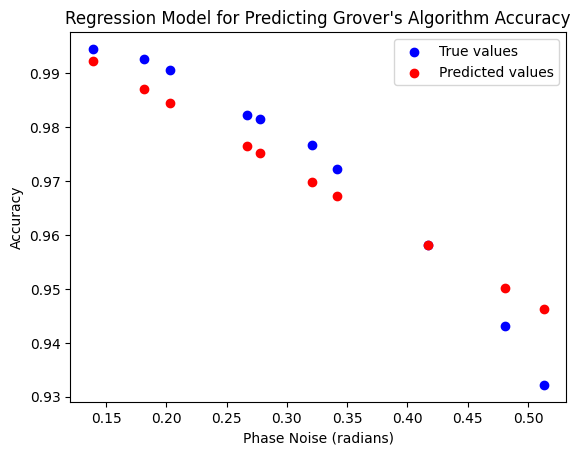

In [20]:
import matplotlib.pyplot as plt

# Plot the true vs predicted values
plt.scatter(X_test, y_test, color='blue', label='True values')
plt.scatter(X_test, y_pred, color='red', label='Predicted values')
plt.xlabel('Phase Noise (radians)')
plt.ylabel('Accuracy')
plt.title('Regression Model for Predicting Grover\'s Algorithm Accuracy')
plt.legend()
plt.show()
